# Model 

In [1]:
import sys
sys.path.append('../src')  # Adjust the path as necessary.
from data.data import ImagesWHighDimLabels
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt

In [40]:
image_save_dir = "../data/imgs/cifar10"
label_save_dir = "../data/labels/categorical/"
image_file_names = ["cifar10_train_img.npy", "cifar10_test_img.npy"]
label_file_names = ["cifar10_training.npy", "cifar10_test.npy"]

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

classes = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
label_map = {idx: label for idx, label in enumerate(classes)}

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean,
                         std=std)
])

img_path = os.path.join(image_save_dir, image_file_names[0])
cat_label_path = os.path.join(label_save_dir, label_file_names[0])
high_dim_labels_path = "../data/labels/high_dim/cifar10_speech.npy"

traindata = ImagesWHighDimLabels(img_path, cat_label_path, high_dim_labels_path, label_map,
                                      transform=transform)

AttributeError: 'tuple' object has no attribute 'shape'

## Model Scratch

In [6]:
from utils import Model, Trainer
from data import ImagesWHighDimLabels
from models import HighDimModel
from torchvision import models
import torch

network = HighDimModel(models.vgg11(), 64)
optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.HuberLoss()
model = Model(network, optimizer, loss_fn)
high_dim_labels = traindata.high_dim_labels
trainloader = DataLoader(traindata, batch_size=16,
                             shuffle=True, num_workers=2)
inputs, high_dim_labels, cat_labels = next(iter(trainloader))

In [10]:
preds = model.forward(inputs)

In [28]:
high_dim_labels.shape

torch.Size([16, 64, 64])

In [12]:
preds.shape

torch.Size([16, 64, 64])

In [13]:
loss_fn = nn.HuberLoss()
y_hats = model.forward(inputs)

In [38]:
pred_classes = classify_predictions(y_hats, high_dim_labels, loss_fn)
a, b = calc_cls_accuracy(pred_classes, cat_labels)

In [39]:
a

2

In [20]:
preds = pred_classes.numpy()

In [19]:
cat_labels 

tensor([0, 2, 6, 1, 8, 1, 9, 1, 2, 4, 0, 0, 4, 9, 9, 6])

In [33]:
traindata[0]

(tensor([[[-1.0527e+00, -1.3068e+00, -1.1956e+00,  ...,  5.1906e-01,
            4.2380e-01,  3.6029e-01],
          [-1.7354e+00, -1.9895e+00, -1.7037e+00,  ..., -3.6628e-02,
           -1.0013e-01, -5.2505e-02],
          [-1.5926e+00, -1.7354e+00, -1.2115e+00,  ..., -1.1601e-01,
           -8.4258e-02, -2.5890e-01],
          ...,
          [ 1.3129e+00,  1.2018e+00,  1.1541e+00,  ...,  5.5081e-01,
           -1.1004e+00, -1.1480e+00],
          [ 8.6835e-01,  7.5721e-01,  9.6361e-01,  ...,  9.3186e-01,
           -4.4942e-01, -6.7170e-01],
          [ 8.2072e-01,  6.7783e-01,  8.5247e-01,  ...,  1.4399e+00,
            4.0792e-01, -3.6628e-02]],
 
         [[-9.8380e-01, -1.2420e+00, -1.2097e+00,  ...,  1.4587e-01,
            3.2906e-02,  1.6768e-02],
          [-1.6616e+00, -1.9844e+00, -1.8553e+00,  ..., -5.6421e-01,
           -6.4490e-01, -5.8034e-01],
          [-1.5970e+00, -1.8714e+00, -1.5486e+00,  ..., -6.2876e-01,
           -6.2876e-01, -8.0628e-01],
          ...,
    

In [36]:
def calc_losses_across_classes(predictions, labels, loss_fn):
    losses = torch.zeros(predictions.size(0), labels.size(0))
    for i, y_hat in enumerate(y_hats):
        for j, label in enumerate(labels):
            loss = loss_fn(y_hat.unsqueeze(0), label.unsqueeze(0))  # Adding batch dimension for compatibility
            losses[i, j] = loss
    return losses

def classify_predictions(predictions, labels, loss_fn):
    losses = calc_losses_across_classes(predictions, labels, loss_fn)
    return torch.argmax(losses, dim=1)

def calc_cls_accuracy(yhat_cls, cat_label):
        check = yhat_cls == cat_label
        num_accurate = sum(check).item()
        num_inaccurate = yhat_cls.size(0) - num_accurate
        return num_accurate, num_inaccurate


In [31]:
losses = []
rate = 3
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model.forward(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % rate == rate-1:
            print(i)
            loss_for_logging = running_loss/rate
            losses.append(loss_for_logging)
            running_loss = 0.0
print('Finished Training')

0
1


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

## CNN 

In [24]:
class CnnFeatureExtractor(nn.Module):
    def __init__(self, base_model: nn.Module):
        super().__init__()
        self.layers = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.classifier[0].in_features

    def forward(self, x):
        h = self.layers(x)
        h = h.flatten(start_dim=1)
        return h




## FC

In [ ]:
fc = nn.Sequential(nn.BatchNorm1d(self.cnn.out_features), # turn features into 1d latent representation
                  nn.LeakyReLU(),
                nn.Linear(self.cnn.out_features, lr_size))

## Decoder 

In [18]:
class DeconvDecoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(input_size, 64, 4, 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            # state size. 64 x 4 x 4
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            # state size. 32 x 8 x 8
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            # state size. 16 x 16 x 16
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            # state size. 8 x 32 x 32
            nn.ConvTranspose2d(8, 1, 4, 2, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)        
        y_hat = self.layers(x)
        return y_hat

In [14]:
class HighDimModel(nn.Module):
    def __init__(self, base_cnn: nn.Module, lr_size: int):
        super().__init__()

        self.cnn = CnnFeatureExtractor(base_cnn) #extracts features from input image
        self.fc = nn.Sequential(nn.BatchNorm1d(self.cnn.out_features), # turn features into 1d latent representation
                  nn.LeakyReLU(),
                nn.Linear(self.cnn.out_features, lr_size))
        self.decoder = DeconvDecoder(lr_size) 

    def forward(self, x):
        h = self.cnn(x)
        lr = self.fc(h)
        y_hat = self.decoder(lr)
        y_hat = y_hat.view(-1, 64, 64)
        return y_hat

In [186]:
full_model = HighDimModel(models.vgg11(), 64)
loss_fn = nn.HuberLoss()
optimizer = optim.SGD(full_model.parameters(), lr=0.001, momentum=0.9)

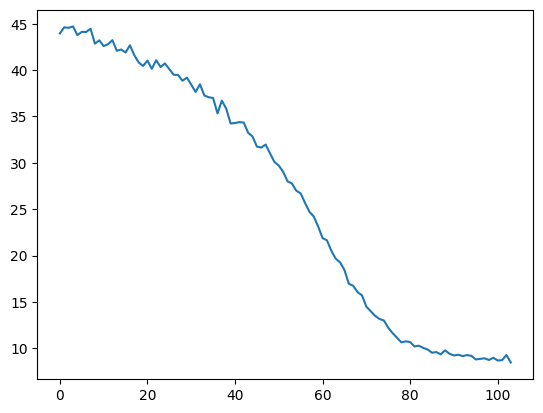